# 肝脏CT图像批量分割

## 1. 导入库

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import time
from tqdm.notebook import tqdm
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# DPU库
from pynq_dpu import DpuOverlay

print("✓ 所有库导入成功")

✓ 所有库导入成功


## 2. 配置参数

In [3]:
# 基本参数
INPUT_SIZE = (512, 512)
IMG_MEAN = np.array([104.00698793, 116.66876762, 122.67891434], dtype=np.float32)
MIN_AREA_THRESHOLD = 1000

# 文件路径
MODEL_PATH = 'unet_chaos-CT_pt.xmodel'
INPUT_PNG_FOLDERS = ['images_1', 'images_2']
INPUT_NPY_FOLDER = 'input_npy'  # PNG转NPY的输入文件夹
OUTPUT_NPY_FOLDER = 'output_npy'  # DPU推理结果输出文件夹

print(f"模型文件: {MODEL_PATH}")
print(f"PNG输入文件夹: {INPUT_PNG_FOLDERS}")
print(f"NPY输入文件夹: {INPUT_NPY_FOLDER}")
print(f"NPY输出文件夹: {OUTPUT_NPY_FOLDER}")

模型文件: unet_chaos-CT_pt.xmodel
PNG输入文件夹: ['images_1', 'images_2']
NPY输入文件夹: input_npy
NPY输出文件夹: output_npy


## 3. 创建目录

In [4]:
# 创建必要的目录
os.makedirs(INPUT_NPY_FOLDER, exist_ok=True)
os.makedirs(OUTPUT_NPY_FOLDER, exist_ok=True)

print(f"✓ 创建目录完成:")
print(f"  - 输入NPY目录: {INPUT_NPY_FOLDER}")
print(f"  - 输出NPY目录: {OUTPUT_NPY_FOLDER}")

✓ 创建目录完成:
  - 输入NPY目录: input_npy
  - 输出NPY目录: output_npy


## 4. PNG → NPY 转换函数

In [5]:
def convert_png_to_npy(png_path, npy_path):
    """将PNG图像转换为NPY格式 (参考liver_segmentation_dpu.ipynb的预处理逻辑)"""
    # 读取PNG图像 (BGR格式)
    image = cv2.imread(png_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"无法读取图像: {png_path}")
    
    # 调整到512x512
    image = cv2.resize(image, INPUT_SIZE, interpolation=cv2.INTER_AREA)
    
    # 转换为float32并进行均值减法
    image = np.asarray(image, np.float32)
    image -= IMG_MEAN
    
    # 保持HWC格式，只添加批次维度 [1, 512, 512, 3]
    image = image[np.newaxis, :, :, :]
    
    # 保存为NPY文件
    np.save(npy_path, image)
    
    return image


def batch_convert_png_to_npy(png_folders, npy_output_folder):
    """批量转换PNG到NPY"""
    print("开始PNG → NPY转换...")
    
    # 扫描所有PNG文件
    png_files = []
    for folder in png_folders:
        if os.path.exists(folder):
            files = [f for f in os.listdir(folder) 
                    if f.lower().endswith('.png')]
            for f in files:
                png_files.append((folder, f))
            print(f"{folder}: 找到 {len(files)} 张PNG图像")
    
    if len(png_files) == 0:
        print("没有找到PNG文件!")
        return []
    
    # 批量转换
    converted_files = []
    success_count = 0
    
    for folder, filename in tqdm(png_files, desc="转换PNG→NPY"):
        png_path = os.path.join(folder, filename)
        npy_filename = os.path.splitext(filename)[0] + '.npy'
        npy_path = os.path.join(npy_output_folder, npy_filename)
        
        try:
            convert_png_to_npy(png_path, npy_path)
            converted_files.append((npy_filename, npy_path))
            success_count += 1
        except Exception as e:
            print(f" 转换失败 {filename}: {str(e)}")
    
    print(f"\n 转换完成: {success_count}/{len(png_files)} 个文件")
    return converted_files


print("✓ 转换函数定义完成")

✓ 转换函数定义完成


In [6]:
def load_npy_image(npy_path):
    """加载NPY格式的预处理图像"""
    image = np.load(npy_path)
    return image


def postprocess_output(output, original_shape=None):
    """后处理模型输出，返回NPY格式的分割结果"""
    # Argmax得到分割结果
    mask = np.argmax(output[0], axis=-1)  # [512, 512]
    mask = mask.astype(np.uint8) * 255
    
    # 连通域分析，保留最大区域
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
    if num_labels > 1:
        areas = stats[1:, cv2.CC_STAT_AREA]
        max_idx = np.argmax(areas) + 1
        if areas[max_idx-1] > MIN_AREA_THRESHOLD:
            mask = np.zeros_like(mask, dtype=np.uint8)
            mask[labels == max_idx] = 255
        else:
            mask = np.zeros_like(mask, dtype=np.uint8)
    
    # 如果需要调整到原始尺寸
    if original_shape is not None:
        mask = cv2.resize(mask, (original_shape[1], original_shape[0]), 
                         interpolation=cv2.INTER_NEAREST)
    
    return mask


print("✓ NPY处理函数定义完成")

✓ NPY处理函数定义完成


## 6. 执行PNG → NPY转换

In [7]:
# 执行批量转换
npy_files = batch_convert_png_to_npy(INPUT_PNG_FOLDERS, INPUT_NPY_FOLDER)

if npy_files:
    print(f"\n 转换后的NPY文件保存在: {INPUT_NPY_FOLDER}")
    print(f" 前5个文件:")
    for i, (filename, _) in enumerate(npy_files[:5]):
        print(f"  {i+1}. {filename}")
    
    # 检查第一个NPY文件的形状
    first_npy = np.load(npy_files[0][1])
    print(f"\n NPY文件形状: {first_npy.shape}")
    print(f" 数据类型: {first_npy.dtype}")
    print(f" 值范围: [{first_npy.min():.3f}, {first_npy.max():.3f}]")
else:
    print(" 没有成功转换的NPY文件")

开始PNG → NPY转换...
images_1: 找到 78 张PNG图像
images_2: 找到 108 张PNG图像


转换PNG→NPY:   0%|          | 0/186 [00:00<?, ?it/s]


✅ 转换完成: 186/186 个文件

📁 转换后的NPY文件保存在: input_npy
📄 前5个文件:
  1. i0073,0000b.npy
  2. i0034,0000b.npy
  3. i0047,0000b.npy
  4. i0046,0000b.npy
  5. i0004,0000b.npy

📏 NPY文件形状: (1, 512, 512, 3)
📏 数据类型: float32
📏 值范围: [-122.679, 150.993]


## 7. 加载DPU模型

In [8]:
if npy_files:
    print("正在加载DPU...")
    
    # 加载DPU overlay
    overlay = DpuOverlay("dpu.bit")
    print("✓ DPU overlay加载成功")
    
    # 加载模型
    overlay.load_model(MODEL_PATH)
    print("✓ 模型加载成功")
    
    # 获取DPU runner
    dpu = overlay.runner
    input_tensors = dpu.get_input_tensors()
    output_tensors = dpu.get_output_tensors()
    
    print(f"输入形状: {input_tensors[0].dims}")
    print(f"输出形状: {output_tensors[0].dims}")
else:
    print(" 没有NPY文件，跳过DPU加载")

正在加载DPU...


✓ DPU overlay加载成功
✓ 模型加载成功
输入形状: [1, 512, 512, 3]
输出形状: [1, 512, 512, 2]


## 8. 批量DPU推理 (NPY格式)

In [9]:
if npy_files and 'dpu' in locals():
    print("开始批量DPU推理...")
    
    # 统计信息
    stats = {
        'total': len(npy_files),
        'success': 0,
        'failed': 0,
        'times': [],
        'liver_pixels': []
    }
    
    start_time = time.time()
    
    # 批量处理循环
    for npy_filename, npy_path in tqdm(npy_files, desc="DPU推理"):
        try:
            inference_start = time.time()
            
            # 1. 加载NPY文件
            input_array = load_npy_image(npy_path)
            
            # 2. DPU推理
            input_data = [input_array.astype(np.float32)]
            output_data = [np.empty(tuple(output_tensors[0].dims), dtype=np.float32)]
            
            job_id = dpu.execute_async(input_data, output_data)
            dpu.wait(job_id)
            output = output_data[0]
            
            # 3. 后处理
            mask = postprocess_output(output)
            
            # 4. 保存NPY格式结果
            base_name = os.path.splitext(npy_filename)[0]
            output_npy_path = os.path.join(OUTPUT_NPY_FOLDER, base_name + '_mask.npy')
            np.save(output_npy_path, mask)
            
            # 统计信息
            inference_time = time.time() - inference_start
            liver_pixels = np.sum(mask > 0)
            
            stats['success'] += 1
            stats['times'].append(inference_time)
            stats['liver_pixels'].append(liver_pixels)
            
        except Exception as e:
            stats['failed'] += 1
            print(f" 推理失败 {npy_filename}: {str(e)}")
    
    total_time = time.time() - start_time
    
    print("\n" + "="*50)
    print("批量DPU推理完成!")
    print("="*50)
    
    # 显示统计结果
    print(f"\n 推理统计:")
    print(f"  总文件数: {stats['total']}")
    print(f"  成功推理: {stats['success']}")
    print(f"  推理失败: {stats['failed']}")
    print(f"  成功率: {stats['success']/stats['total']*100:.1f}%")
    
    if stats['times']:
        times = np.array(stats['times'])
        print(f"\n 性能统计:")
        print(f"  总推理时间: {total_time:.2f} 秒")
        print(f"  平均推理速度: {stats['success']/total_time:.2f} 图像/秒")
        print(f"  单张平均时间: {np.mean(times):.3f} ± {np.std(times):.3f} 秒")
        print(f"  最快推理时间: {np.min(times):.3f} 秒")
        print(f"  最慢推理时间: {np.max(times):.3f} 秒")
    
    if stats['liver_pixels']:
        liver_count = sum(1 for p in stats['liver_pixels'] if p > 0)
        nonzero_pixels = [p for p in stats['liver_pixels'] if p > 0]
        
        print(f"\n 肝脏检测统计:")
        print(f"  检测到肝脏: {liver_count}/{stats['success']} ({liver_count/stats['success']*100:.1f}%)")
        
        if nonzero_pixels:
            print(f"  平均肝脏像素: {np.mean(nonzero_pixels):.0f}")
            print(f"  肝脏像素范围: {np.min(nonzero_pixels)} - {np.max(nonzero_pixels)}")
    
    print(f"\n 输入NPY文件: {INPUT_NPY_FOLDER}")
    print(f" 输出NPY文件: {OUTPUT_NPY_FOLDER}")
    
else:
    print(" 没有NPY文件或DPU未加载，跳过推理")

开始批量DPU推理...


DPU推理:   0%|          | 0/186 [00:00<?, ?it/s]


批量DPU推理完成!

📊 推理统计:
  总文件数: 186
  成功推理: 186
  推理失败: 0
  成功率: 100.0%

⏱️ 性能统计:
  总推理时间: 15.15 秒
  平均推理速度: 12.28 图像/秒
  单张平均时间: 0.078 ± 0.031 秒
  最快推理时间: 0.065 秒
  最慢推理时间: 0.296 秒

🫀 肝脏检测统计:
  检测到肝脏: 177/186 (95.2%)
  平均肝脏像素: 16400
  肝脏像素范围: 1173 - 28057

📁 输入NPY文件: input_npy
📁 输出NPY文件: output_npy


## 9. 显示处理结果

找到 108 个输出文件


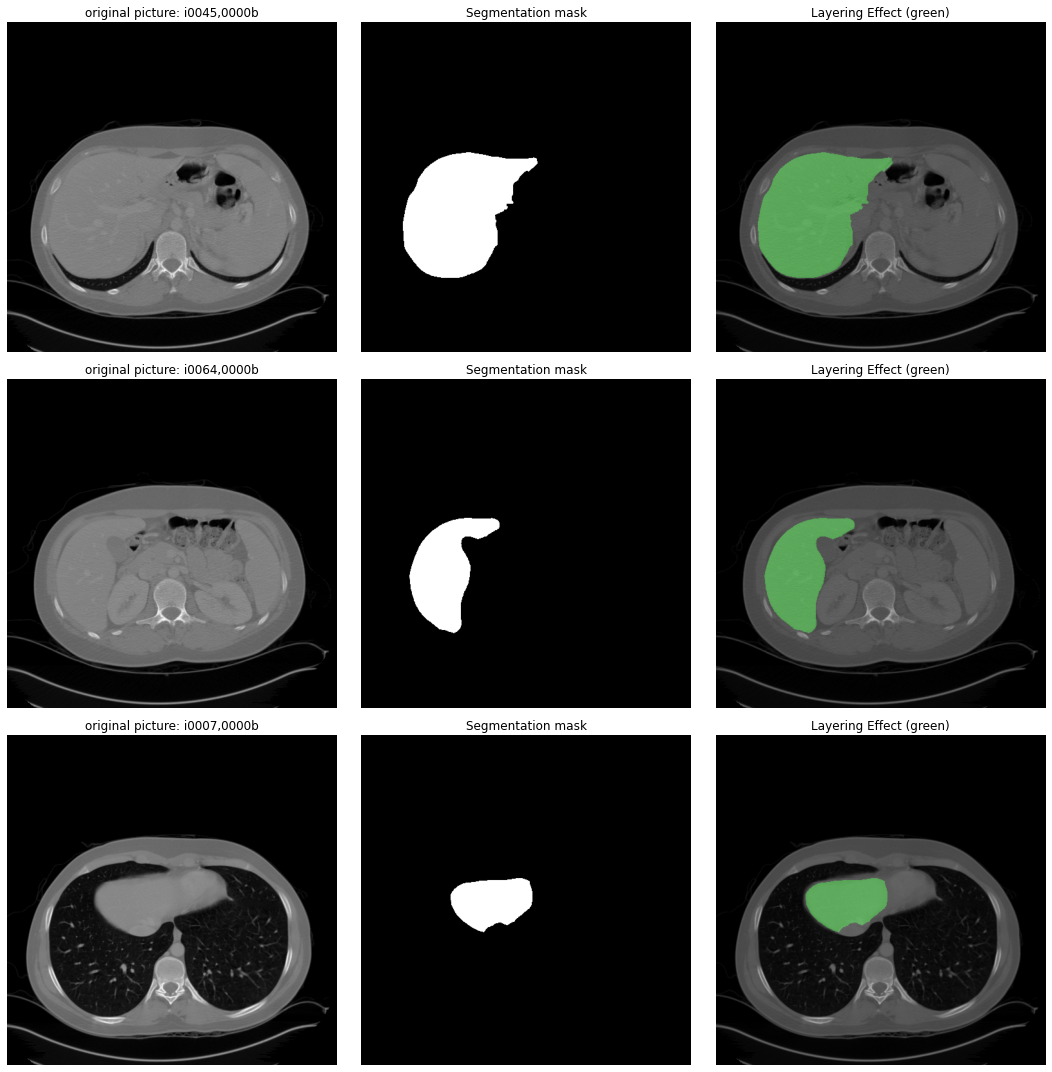


📏 输出NPY文件形状: (512, 512)
📏 输出数据类型: uint8
📏 输出值范围: [0, 255]

🎨 叠加效果统计:
  有肝脏区域的图像: 101/108 (93.5%)
  总肝脏像素数: 1,496,899
  平均肝脏像素/图像: 14821


In [10]:
# 显示一些处理结果
if os.path.exists(OUTPUT_NPY_FOLDER):
    output_files = [f for f in os.listdir(OUTPUT_NPY_FOLDER) if f.endswith('_mask.npy')]
    
    if output_files:
        print(f"找到 {len(output_files)} 个输出文件")
        
        # 显示前3个结果 (改为3列：原图、掩码、叠加效果)
        fig, axes = plt.subplots(len(output_files[:3]), 3, figsize=(15, 5*len(output_files[:3])))
        if len(output_files[:3]) == 1:
            axes = axes.reshape(1, -1)
        
        for i, output_file in enumerate(output_files[:3]):
            # 加载对应的原始NPY和输出NPY
            input_name = output_file.replace('_mask.npy', '.npy')
            input_path = os.path.join(INPUT_NPY_FOLDER, input_name)
            output_path = os.path.join(OUTPUT_NPY_FOLDER, output_file)
            
            if os.path.exists(input_path) and os.path.exists(output_path):
                # 加载数据
                input_data = np.load(input_path)[0]  # [512, 512, 3]
                mask = np.load(output_path)  # [512, 512]
                
                # 反向预处理用于显示
                display_image = (input_data + IMG_MEAN).astype(np.uint8)
                
                # 显示原始图像
                axes[i, 0].imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))
                axes[i, 0].set_title(f'original picture: {os.path.splitext(input_name)[0]}')
                axes[i, 0].axis('off')
                
                # 显示分割结果
                axes[i, 1].imshow(mask, cmap='gray')
                axes[i, 1].set_title(f'Segmentation mask')
                axes[i, 1].axis('off')
                
                # 添加叠加效果显示 
                if np.sum(mask > 0) > 0:  # 如果有肝脏区域
                    overlay_image = display_image.copy()
                    # 创建彩色掩码（绿色）
                    colored_mask = np.zeros_like(overlay_image)
                    colored_mask[mask > 0] = [0, 255, 0]  # 绿色通道
                    # 叠加显示
                    overlay_result = cv2.addWeighted(overlay_image, 0.7, colored_mask, 0.3, 0)
                    axes[i, 2].imshow(cv2.cvtColor(overlay_result, cv2.COLOR_BGR2RGB))
                    axes[i, 2].set_title('Layering Effect (green)')
                else:  # 如果没有肝脏区域
                    axes[i, 2].text(0.5, 0.5, 'not detect', 
                                     ha='center', va='center', transform=axes[i, 2].transAxes, fontsize=12)
                    axes[i, 2].set_title('No liver area')
                
                axes[i, 2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # 检查输出文件信息
        first_output = np.load(os.path.join(OUTPUT_NPY_FOLDER, output_files[0]))
        print(f"\n 输出NPY文件形状: {first_output.shape}")
        print(f" 输出数据类型: {first_output.dtype}")
        print(f" 输出值范围: [{first_output.min()}, {first_output.max()}]")
        
        # 统计有肝脏区域的图像数量 
        liver_count = 0
        for output_file in output_files:
            mask = np.load(os.path.join(OUTPUT_NPY_FOLDER, output_file))
            if np.sum(mask > 0) > 0:
                liver_count += 1
        
        print(f"\n 叠加效果统计:")
        print(f"  有肝脏区域的图像: {liver_count}/{len(output_files)} ({liver_count/len(output_files)*100:.1f}%)")
        
        if liver_count > 0:
            # 计算肝脏像素统计
            total_pixels = 0
            for output_file in output_files:
                mask = np.load(os.path.join(OUTPUT_NPY_FOLDER, output_file))
                total_pixels += np.sum(mask > 0)
            
            print(f"  总肝脏像素数: {total_pixels:,}")
            print(f"  平均肝脏像素/图像: {total_pixels/liver_count:.0f}")
        
    else:
        print("没有找到输出文件")
else:
    print("输出文件夹不存在")

## 10. 清理资源

In [11]:
# 释放DPU资源
try:
    del dpu
    del overlay
    print("✓ DPU资源已释放")
except:
    pass

print("\n NPY格式批量处理完成!")
print(f" 输入NPY文件: {INPUT_NPY_FOLDER}")
print(f" 输出NPY文件: {OUTPUT_NPY_FOLDER}")

✓ DPU资源已释放

🎉 NPY格式批量处理完成!
📁 输入NPY文件: input_npy
📁 输出NPY文件: output_npy


In [12]:
# 彻底清理内存 - 减少内存占用
import gc
import sys

def cleanup_memory():
    """清理内存中的变量和缓存"""
    
    print("🧹 开始清理内存...")
    
    # 1. 清理DPU相关资源 (如果还有残留)
    dpu_vars = ['dpu', 'overlay', 'input_tensors', 'output_tensors']
    for var in dpu_vars:
        if var in globals():
            try:
                del globals()[var]
                print(f"✓ 删除变量: {var}")
            except:
                pass
    
    # 2. 清理大型数组和列表
    array_vars = ['input_array', 'output_data', 'mask', 'first_npy', 'output']
    for var in array_vars:
        if var in globals():
            try:
                del globals()[var]
                print(f"✓ 删除数组: {var}")
            except:
                pass
    
    # 3. 清理文件列表和统计信息
    list_vars = ['npy_files', 'output_files', 'converted_files']
    for var in list_vars:
        if var in globals():
            try:
                del globals()[var]
                print(f"✓ 删除列表: {var}")
            except:
                pass
    
    # 4. 清理统计字典
    dict_vars = ['stats']
    for var in dict_vars:
        if var in globals():
            try:
                del globals()[var]
                print(f"✓ 删除字典: {var}")
            except:
                pass
    
    # 5. 强制垃圾回收
    collected = gc.collect()
    print(f"✓ 垃圾回收完成，清理了 {collected} 个对象")
    
    # 6. 清理matplotlib缓存
    try:
        plt.close('all')
        print("✓ 清理matplotlib图形缓存")
    except:
        pass
    
    # 7. 显示内存使用情况
    try:
        import psutil
        process = psutil.Process()
        memory_info = process.memory_info()
        memory_mb = memory_info.rss / 1024 / 1024
        
        print(f"\n📊 当前内存使用情况:")
        print(f"  RSS内存: {memory_mb:.1f} MB")
        print(f"  VMS内存: {memory_info.vms / 1024 / 1024:.1f} MB")
        
        if memory_mb > 1000:  # 如果内存使用超过1GB
            print("⚠️  内存使用较高，建议重启kernel")
        else:
            print("✓ 内存使用正常")
            
    except ImportError:
        print("  (psutil未安装，无法显示内存信息)")
    
    return memory_mb if 'memory_mb' in locals() else None

# 执行内存清理
final_memory = cleanup_memory()

print(f"\n🎉 内存清理完成!")
print(f"📁 输入NPY文件保留在: {INPUT_NPY_FOLDER}")
print(f"📁 输出NPY文件保留在: {OUTPUT_NPY_FOLDER}")
print(f"\n💡 提示: 如需进一步释放内存，可以重启Jupyter kernel")

🧹 开始清理内存...
✓ 删除变量: input_tensors
✓ 删除变量: output_tensors
✓ 删除数组: input_array
✓ 删除数组: output_data
✓ 删除数组: mask
✓ 删除数组: first_npy
✓ 删除数组: output
✓ 删除列表: npy_files
✓ 删除列表: output_files
✓ 删除字典: stats
✓ 垃圾回收完成，清理了 95 个对象
✓ 清理matplotlib图形缓存

📊 当前内存使用情况:
  RSS内存: 234.3 MB
  VMS内存: 1566.5 MB
✓ 内存使用正常

🎉 内存清理完成!
📁 输入NPY文件保留在: input_npy
📁 输出NPY文件保留在: output_npy

💡 提示: 如需进一步释放内存，可以重启Jupyter kernel
